In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from Simulation import *

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

In [2]:
# Aspen connection
cwd = os.getcwd()
sim = Simulation("ORC.bkp", cwd)

# Molecular weights

MW = {
    "BUTANE": 58.12,
    "PENTANE": 72.15,
    "ISOBUT": 58.12,
    "ISOPEN": 72.15,
    "R113": 187.38,
    "R114": 170.9,
    "R123": 152.93,
    "R124": 136.48
}

GWP = {
    "BUTANE": 4,
    "PENTANE": 5,
    "ISOBUT": 3,
    "ISOPEN": 5,
    "R113": 6000,
    "R114": 9800,
    "R123": 120,
    "R124": 620
}

class MyProblem(ElementwiseProblem):

    def __init__(self, aspen):
        super(MyProblem, self).__init__(n_var=9, n_obj=2, n_ieq_constr=1,
            xl=np.zeros((9, ), dtype=np.float32), 
            xu=np.array([1,1,1,1,1,1,1,1,10], dtype=np.float32))
        
        self.aspen = aspen

    def _evaluate(self, x, out, *args, **kwargs):

        # Inlet composition
        inlet_comp = {
            "BUTANE": x[0],
            "PENTANE": x[1],
            "ISOBUT": x[2],
            "ISOPEN": x[3],
            "R113": x[4],
            "R114": x[5],
            "R123": x[6],
            "R124": x[7]
        }

        inlet_flow = [25.0, 1.0, inlet_comp]

        s1 = Stream(inlet_flow)
        pump = Pump(x[8])
        turb = Turbine()
        boiler = Boiler()
        cond = Condenser()

        self.aspen.EngineRun()

        # Constraint

        g1 = (sum(x[:8]) - 1)**2 - 1e-10

        # Objective 1 - Efficiency (maximize)
        qin = boiler.enery_consumption()
        wout = turb.enery_consumption()
        win = pump.enery_consumption()
        eff = - (np.abs(wout - win)/qin)

        # Objective 2 - Environmental impact (minimize)
        env = sum(MW[compound] * GWP[compound] * inlet_comp[compound] for compound in MW.keys())
        

        
        out["F"] = [eff, env]
        out["G"] = [g1]

problem = MyProblem(aspen=sim)


algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)


termination = get_termination("n_gen", 150)


res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)


sim.CloseAspen()

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  1.4658159668 |  1.033077E+01 |             - |             -
     2 |       50 |      1 |  1.4658159668 |  7.9177882511 |             - |             -
     3 |       60 |      1 |  1.4658159668 |  6.1941558533 |             - |             -
     4 |       70 |      1 |  1.4658159668 |  5.0536774426 |             - |             -
     5 |       80 |      1 |  1.4658159668 |  3.8873180301 |             - |             -
     6 |       90 |      1 |  1.4658159668 |  3.2541903693 |             - |             -
     7 |      100 |      1 |  1.1030486290 |  2.8579221671 |             - |             -
     8 |      110 |      1 |  0.3676052256 |  2.4482482712 |             - |             -
     9 |      120 |      1 |  0.1340562287 |  2.1495906308 |             - |             -
    10 |      130 |      1 |  0.0909144561 |  1.8474572849 |             - |             -

In [3]:
X = res.X
F = res.F
print(F)
print(X)

[[-8.38012633e-02  1.31444107e+05]
 [-8.38012626e-02  1.31441400e+05]
 [-8.38012634e-02  1.31444422e+05]
 [-8.38012637e-02  1.31444442e+05]
 [-8.38012607e-02  1.31438060e+05]
 [-8.38012619e-02  1.31440806e+05]
 [-8.38012612e-02  1.31438110e+05]
 [-8.38012635e-02  1.31444442e+05]
 [-8.38012630e-02  1.31442356e+05]
 [-8.38012634e-02  1.31444416e+05]
 [-8.38012631e-02  1.31442810e+05]
 [-8.38012624e-02  1.31441186e+05]]
[[4.02564946e-01 8.74035502e-02 3.87043583e-02 1.47113596e-01
  1.11445997e-01 3.69392764e-06 1.81810816e-01 3.09623150e-02
  6.71665406e+00]
 [4.02564946e-01 8.74035502e-02 3.87043583e-02 1.47113596e-01
  1.11445997e-01 2.07742387e-06 1.81810816e-01 3.09623124e-02
  7.06873772e+00]
 [4.02564945e-01 8.74035502e-02 3.87043583e-02 1.47113596e-01
  1.11445997e-01 3.88167744e-06 1.81810816e-01 3.09623124e-02
  6.39889061e+00]
 [4.02564947e-01 8.74035502e-02 3.87043583e-02 1.47113596e-01
  1.11445997e-01 3.89403801e-06 1.81810816e-01 3.09623124e-02
  6.36425965e+00]
 [4.0256494

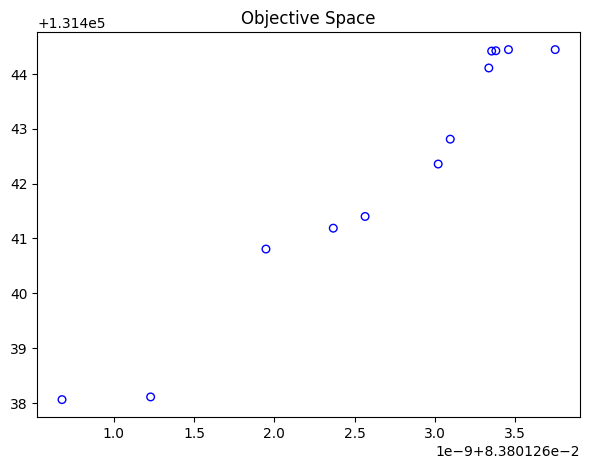

In [4]:
plt.figure(figsize=(7, 5))
plt.scatter(-F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()